In [1]:
# write your code here
# write your code here
from sklearn import datasets,model_selection
import numpy as np
from scipy.sparse import hstack, csr_matrix


class LinearClassification():
    def __init__(self):
        pass

    @staticmethod
    def gradient(X, y, theta, C=1):
        ## set the y_i where 1 - y * X.dot(theta) < 0 to 0 
        index =  (1 - y * X.dot(theta) < 0)
        y_copy = y.copy()
        y_copy[index] = 0
        
        #compute gradient and update parameter of model 
        epsilon_gradient = -np.dot(X.transpose(), y_copy)  ###
        gradient = theta + C * epsilon_gradient
        return gradient
    
    @staticmethod
    def train(X_train, y_train, theta, episode, learning_rate,  C=1, optimizer=None, optimizer_params={}):
        if optimizer==None:
            # train, update theta
            grad = LinearClassification.gradient(X_train, y_train, theta, C)
            theta -= learning_rate*grad
        elif optimizer == "NAG":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            momemtum = optimizer_params.setdefault('momemtum', 0.9)
            
            #train ,update theta with NAG optimizer
            grad = LinearClassification.gradient(X_train, y_train, theta+ momemtum*Velocity, C)
            Velocity = momemtum*Velocity - learning_rate*grad
            theta += Velocity
            
            #store the parameter of optimizer
            optimizer_params['Velocity'] = Velocity
        elif optimizer == "RMSprop":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            decay_rate = optimizer_params.setdefault('decay_rate', 0.9)
            epsilon = optimizer_params.setdefault('epsilon', 1e-7)
            
            #train, update with RMSprop optimizer
            grad = LinearClassification.gradient(X_train, y_train, theta, C)
            Velocity = decay_rate*Velocity + (1-decay_rate)*(grad**2)            
            theta -= learning_rate*grad/(np.sqrt(epsilon) + Velocity)
            
            #store the parameter of optimizer
            optimizer_params['Velocity'] = Velocity
        elif optimizer == "Adadelta":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            update_accumulate = optimizer_params.setdefault('update_accumulate', np.zeros(theta.shape))
            decay_rate = optimizer_params.setdefault('decay_rate', 0.9)
            epsilon = optimizer_params.setdefault('epsilon', 1e-7)
            
            #train, update with Adadelta optimizer
            grad = LinearClassification.gradient(X_train, y_train, theta, C)
            Velocity = decay_rate*Velocity + (1-decay_rate)*(grad**2)
            step_update = -(np.sqrt(update_accumulate+epsilon))*grad/(np.sqrt(Velocity+epsilon))
            # step_update = - (np.sqrt(Velocity) + epsilon) * grad / (np.sqrt(Velocity) + epsilon)
            theta +=  step_update
            update_accumulate = decay_rate*update_accumulate + (1-decay_rate)*(step_update**2)
            
            #store the parameter of optimizer
            optimizer_params['update_accumulate'] = update_accumulate
            optimizer_params['Velocity'] = Velocity
        elif optimizer == "Adam":
            Velocity = optimizer_params.setdefault('Velocity', np.zeros(theta.shape))
            S = optimizer_params.setdefault('S', np.zeros(theta.shape))
            beta1 =  optimizer_params.setdefault('beta1', 0.9)
            beta2 = optimizer_params.setdefault('beta2', 0.999)
            epsilon = optimizer_params.setdefault('epsilon', 1e-8)
            
            #train, update theta with Adam optimizer
            grad = LinearClassification.gradient(X_train, y_train, theta, C)
            S = beta1*S + (1-beta1)*grad
            Velocity = beta2*Velocity + (1-beta2)*(grad**2)
            
            S_t = S/(1 - (beta1**episode))
            Velocity_t = Velocity/(1- (beta2**episode))
            step_update = - learning_rate * S_t/ (np.sqrt(Velocity_t) + epsilon)
            theta += step_update
            
            #store the parameter of optimizer
            optimizer_params['S'] = S
            optimizer_params['Velocity'] = Velocity
        return theta

    @staticmethod
    def loss_function(X, y, theta, C=1):
        #compute the loss of the model 
        epsilon_loss = 1 - y * X.dot(theta)
        epsilon_loss[epsilon_loss<0] = 0
        loss = 0.5 * np.dot(theta.transpose(), theta).sum() + C*epsilon_loss.sum()
        return loss/X.shape[0]

    @staticmethod
    def accuracy_of_classification(X, y, theta, threshold=0):
        y_prediction = X.dot(theta)
        # calssification
        y_prediction[y_prediction<threshold] = -1
        y_prediction[y_prediction>=threshold] = 1
        
        #compute accuray of classifica
        classification = y*y_prediction
        classification[classification==-1] = 0
        accuracy = classification.sum()/classification.shape[0]
        return accuracy

In [8]:

def data_loader(file, n_features=None):
    if n_features:
        inputs,labels = datasets.load_svmlight_file(file, n_features)
    else:
        inputs,labels = datasets.load_svmlight_file(file)
    #preprocess the data, change y=wx+b to y=wx', where x'is one more cloumn than x
    one = np.ones((inputs.shape[0],1))
    inputs = hstack( [inputs, csr_matrix(one)] ).toarray()  # change the type of inputs from matrix to ndarray
    labels = np.array(labels).reshape(inputs.shape[0],1)
    return inputs, labels

def get_batch(X, y ,mini_batch):
    """use to select the samples randomly"""
    index = np.random.randint(0,X.shape[0], size=mini_batch, dtype=int)
    return X[index,:], y[index]

def plot_loss(test_loss, test_accuracy):
    import matplotlib.pyplot as plt
    figure1 = plt.figure(1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(test_loss, label="test_loss")
    plt.legend(loc='upper right')

    plt.figure(2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(test_accuracy)
    plt.show()

def main(train_file, test_file, learning_rate, threshold=0, C=1, mini_batch=64, epoch=1000,optimizer=None, optimizer_params={}):
    X_train,y_train = data_loader(train_file)
    X_test, y_test = data_loader(test_file, n_features=X_train.shape[1]-1)
    theta = np.random.random((X_train.shape[1],1))
    model = LinearClassification()
    train_loss = []
    test_loss = []
    test_accuracy =[]
    for episode in range(1,epoch):
        X_train_batch, y_train_batch = get_batch(X_train, y_train, mini_batch)  # choose mini_batch samples
        theta = model.train(X_train_batch, y_train_batch, theta, episode, learning_rate, C, 
                            optimizer=optimizer, optimizer_params=optimizer_params)
        
        loss = model.loss_function(X_train_batch, y_train_batch, theta, C)
        train_loss.append(loss)

        X_test_batch, y_test_batch = get_batch(X_test, y_test, mini_batch)  # choose mini_batch samples
        loss = model.loss_function(X_test_batch, y_test_batch, theta, C)
        test_loss.append(loss)
        accuracy = model.accuracy_of_classification(X_test_batch, y_test_batch, theta, threshold)
        test_accuracy.append(accuracy)
    plot_loss(test_loss, test_accuracy)
    print("lower loss: ", min(test_loss))
    print("classification accuracy: ", max(test_accuracy))

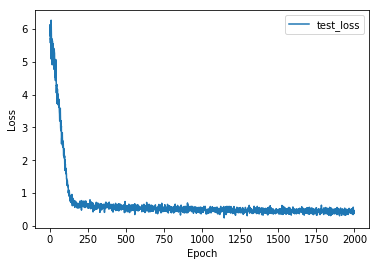

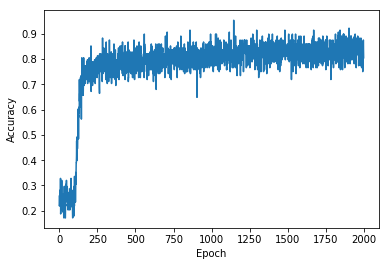

lower loss:  0.242785857476
classification accuracy:  0.953125


In [12]:
# trian with NAG optimizer
train_params = {
    'train_file': 'a9a.txt',
    'test_file': 'a9a.t',
    'learning_rate': 1e-5,           # SGD: 25e-6, NAG:25e-6, RMSprop: 1e-3/1e-4, Adadelta: 1e-3,  Adam:1e-3
    'C': 9e-1,                       # SGD: 9e-1, NAG:9e-1, RMSprop: 9e-3 ,Adadelta: 9e-1,  Adam:9e-1
    'epoch': 2000,                   # SGD: 1000, NAG:1000, RMSprop: 1000/10000, Adadelta:1000, Adam:1000
    'threshold': 0,
    'mini_batch': 128,
    'optimizer': "NAG"
}
optimizer_params={
    'momemtum': 0.9,
    'decay_rate': 0.9,
    'epsilon':1e-8,
    'beta1':0.9,
    'beta2':0.99
}
main(**train_params)

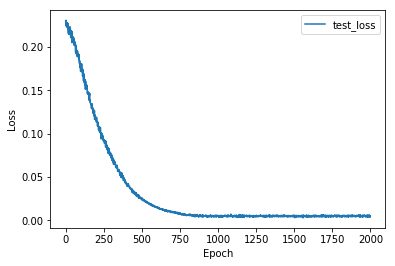

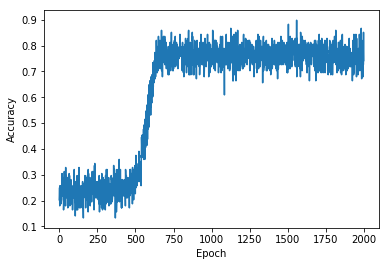

lower loss:  0.00287358746064
classification accuracy:  0.8984375


In [14]:
# trian with RMSprop optimizer
train_params = {
    'train_file': 'a9a.txt',
    'test_file': 'a9a.t',
    'learning_rate': 1e-3,           # SGD: 25e-6, NAG:25e-6, RMSprop: 1e-3/1e-4, Adadelta: 1e-3,  Adam:1e-3
    'C': 9e-3,                       # SGD: 9e-1, NAG:9e-1, RMSprop: 9e-3 ,Adadelta: 9e-1,  Adam:9e-1
    'epoch': 2000,                   # SGD: 1000, NAG:1000, RMSprop: 1000/10000, Adadelta:1000, Adam:1000
    'threshold': 0,
    'mini_batch': 128,
    'optimizer': "RMSprop"
}
optimizer_params={
    'momemtum': 0.9,
    'decay_rate': 0.9,
    'epsilon':1e-8,
    'beta1':0.9,
    'beta2':0.99
}
main(**train_params)

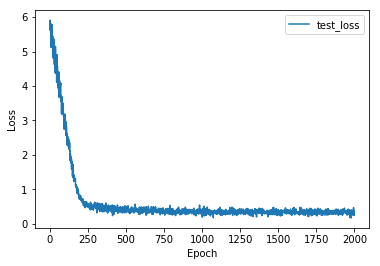

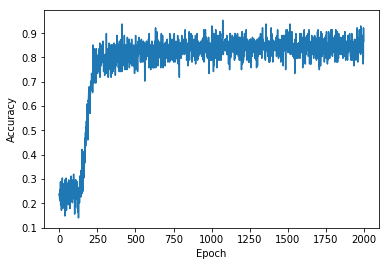

lower loss:  0.176022103304
classification accuracy:  0.953125


In [18]:
# trian with RMSprop optimizer
train_params = {
    'train_file': 'a9a.txt',
    'test_file': 'a9a.t',
    'learning_rate': 1e-4,           # SGD: 25e-6, NAG:25e-6, RMSprop: 1e-3/1e-4, Adadelta: 1e-3,  Adam:1e-3
    'C': 9e-1,                       # SGD: 9e-1, NAG:9e-1, RMSprop: 9e-3 ,Adadelta: 9e-1,  Adam:9e-1
    'epoch': 2000,                   # SGD: 1000, NAG:1000, RMSprop: 1000/10000, Adadelta:1000, Adam:1000
    'threshold': 0,
    'mini_batch': 128,
    'optimizer': "Adadelta"
}
optimizer_params={
    'momemtum': 0.9,
    'decay_rate': 0.9,
    'epsilon':1e-8,
    'beta1':0.9,
    'beta2':0.99
}
main(**train_params)

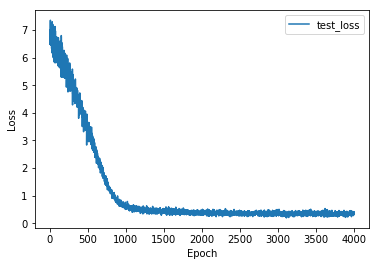

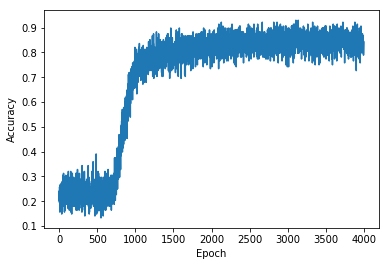

lower loss:  0.195718822408
classification accuracy:  0.9296875


In [21]:
# trian with RMSprop optimizer
train_params = {
    'train_file': 'a9a.txt',
    'test_file': 'a9a.t',
    'learning_rate': 1e-3,           # SGD: 25e-6, NAG:25e-6, RMSprop: 1e-3/1e-4, Adadelta: 1e-3,  Adam:1e-3
    'C': 9e-1,                       # SGD: 9e-1, NAG:9e-1, RMSprop: 9e-3 ,Adadelta: 9e-1,  Adam:9e-1
    'epoch': 4000,                   # SGD: 1000, NAG:1000, RMSprop: 1000/10000, Adadelta:1000, Adam:1000
    'threshold': 0,
    'mini_batch': 128,
    'optimizer': "Adam"
}
optimizer_params={
    'momemtum': 0.9,
    'decay_rate': 0.9,
    'epsilon':1e-8,
    'beta1':0.9,
    'beta2':0.99
}
main(**train_params)